In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import os
import sys
sys.path.insert(0, 'python')
from geo_trans import *
from Dload_Finder import file_finder
import datetime
import glob
from cloud import get_cloud_mask
from classification import *
from get_brdf import *
import multiprocessing
from scipy import ndimage, signal, optimize
import scipy
from linear_plot import *
from fastRWpkl import *

In [3]:
lat, lon, year, month, day = 37.181944, 114.36, 2016, 5, 3 

In [4]:
h,v = mtile_cal(lat, lon)
m = mgrs.MGRS()
mg_coor = m.toMGRS(lat, lon, MGRSPrecision=4)
place = mg_coor[:5]
fnames = []
directory  = os.getcwd()+'/s_data/%s/%s/%s/%d/'%(mg_coor[:2], mg_coor[2], mg_coor[3:5], year)
for path, subdirs, files in os.walk(directory):
    if 'B01.jp2' in files:
        fnames.append( os.path.join(path))

In [5]:
doy = datetime .datetime(year, month, day).timetuple().tm_yday
doy

124

In [6]:
Hfile = os.getcwd()+'/s_data/%s/%s/%s/%d/%d/%d/0/'%(mg_coor[:2], mg_coor[2], mg_coor[3:5], year, month, day)
Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,i,h,v))[0] for i in range(doy-8, doy+9)]
Lfiles

['m_data/MCD43A1.A2016116.h27v05.006.2016180182935.hdf',
 'm_data/MCD43A1.A2016117.h27v05.006.2016180184807.hdf',
 'm_data/MCD43A1.A2016118.h27v05.006.2016180190640.hdf',
 'm_data/MCD43A1.A2016119.h27v05.006.2016180192910.hdf',
 'm_data/MCD43A1.A2016120.h27v05.006.2016180195231.hdf',
 'm_data/MCD43A1.A2016121.h27v05.006.2016180201154.hdf',
 'm_data/MCD43A1.A2016122.h27v05.006.2016180202755.hdf',
 'm_data/MCD43A1.A2016123.h27v05.006.2016180204842.hdf',
 'm_data/MCD43A1.A2016124.h27v05.006.2016180210538.hdf',
 'm_data/MCD43A1.A2016125.h27v05.006.2016180212518.hdf',
 'm_data/MCD43A1.A2016126.h27v05.006.2016180214554.hdf',
 'm_data/MCD43A1.A2016127.h27v05.006.2016180220507.hdf',
 'm_data/MCD43A1.A2016128.h27v05.006.2016180222324.hdf',
 'm_data/MCD43A1.A2016129.h27v05.006.2016180223930.hdf',
 'm_data/MCD43A1.A2016130.h27v05.006.2016180225447.hdf',
 'm_data/MCD43A1.A2016131.h27v05.006.2016180231424.hdf',
 'm_data/MCD43A1.A2016132.h27v05.006.2016180233003.hdf']

In [3]:
import sys
sys.path.insert(0,'python')
from Dload_Finder import *
import multiprocessing
from fft_helper import *
from functools import partial

class PSF_optimization():
    def __init__(self, year, month, day, doy, lat, lon, sate):
        self.year = year
        self.doy = doy
        self.month = month
        self.day= day
        self.lat = lat
        self.lon = lon
        self.sate = sate 
        self.Lx = None
        self.LY = None
        self.Hx = None
        self.Hy = None
        self.H_data = None
        self.L_data = None
        self.sza = None
        self.saa = None
        self.vza = None
        self.vaa = None
        self.retval = None
        self.BRDF_16_days =None
        self.composite_brdf = None
        self.base_mask = None
        
    def read_meta(self, Hfile, path=None, row=None):
    
        with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if 'CLOUD_COVER ' in line:
                    cloud_cover =  float(line.split('= ')[1])
        if cloud_cover<20:
            #print 'Less than 20% cloud.'
            b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
            corners = b1.shape
            dic = {}
            with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
                for line in inF:
                    if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                        dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                    elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                        dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                    elif 'ROLL_ANGLE' in line:
                        vza = float(line.split(' = ')[1])
                    elif 'SUN_AZIMUTH' in line:
                        saa = float(line.split(' = ')[1])
                    elif 'SUN_ELEVATION' in line:
                        sza = float(line.split(' = ')[1])
            with open('Landsat_azm.pkl', 'r') as savefile:
                Landsat_azm = pkl.load(savefile)

            vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])

            return sza, saa, vza, vaa, dic, corners
        else:
            print 'To much cloud: ', cloud_cover
            return None  

    def update_mask(self, base_map,forward_8_days, backward_8_days, pre_mask, qa=0, start_point=4, thresh=0.005):

        for i in range(8):
            qa_fo_mask = forward_8_days[-(i+1),1,:]<=qa
            qa_ba_mask = backward_8_days[i,1,:]<=qa
            dif = np.abs(forward_8_days[i,0,:] - backward_8_days[-(i+1),0,:])
            dif_mask = (dif/np.abs(forward_8_days[i,0,:])) <thresh
            non_negative_mask = (forward_8_days[i,0,:]>0) & (backward_8_days[-(i+1),0,:]>0)

            i_day_mask = (qa_fo_mask | qa_ba_mask)&dif_mask&non_negative_mask
            current_mask = (~pre_mask)&i_day_mask
            base_map[current_mask] = i+start_point
            pre_mask = pre_mask|current_mask  
        return base_map, pre_mask
    
    def compositing(self, angles, thre=0.005):
        BRDF_16_days = np.array([get_brdf_six(Lfile,angles,bands=(7,), \
                                              flag=None, Linds= self.L_inds) for Lfile in self.Lfiles]).squeeze()

        backward_8_days,mid_day, forward_8_days = BRDF_16_days[:8], BRDF_16_days[8], BRDF_16_days[9:]

        qa_mask_0 = np.all(BRDF_16_days[:,1,:]<=0, axis=0)
        stable_mask_0 =  BRDF_16_days[:,0,:].std(axis=0)<0.005
        filter_mask_0 = qa_mask_0&stable_mask_0

        qa_mask_1 = np.all(BRDF_16_days[:,1,:]<=1, axis=0)
        stable_mask_1 =  BRDF_16_days[:,0,:].std(axis=0)<0.004
        filter_mask_1 = qa_mask_1&stable_mask_1&np.all(BRDF_16_days[:,0,:]>=0, axis=0)


        base_mask = np.zeros(len(self.L_inds[0]))
        current_mask = filter_mask_0
        base_mask[current_mask] = 1
        previous_mask = current_mask

        current_mask = (~previous_mask)&filter_mask_1 #| ((mid_day[1]==0)&stable_mask)
        base_mask[current_mask] = 2
        previous_mask = previous_mask|current_mask

        current_mask = (~previous_mask)&((mid_day[1]==0)&stable_mask_0)
        base_mask[current_mask] = 3
        previous_mask = previous_mask|current_mask

        base_mask, pre_mask = self.update_mask(base_mask,forward_8_days, backward_8_days, previous_mask, qa=0, start_point=4)
        base_mask, _mask = self.update_mask(base_mask, forward_8_days, backward_8_days, pre_mask, qa=1, start_point=12,thresh=0.00025)

        composite_brdf = np.zeros(base_mask.shape)
        composite_brdf[:]=np.nan
        composite_brdf[base_mask==1] = mid_day[0][base_mask==1]
        composite_brdf[base_mask==2] = mid_day[0][base_mask==2]
        composite_brdf[base_mask==3] = mid_day[0][base_mask==3]

        for i in range(8):
            composite_brdf[base_mask==i+4] = forward_8_days[i][0][base_mask==i+4]
        for i in range(8):
            composite_brdf[base_mask==i+12] = backward_8_days[-(i+1)][0][base_mask==i+12]

        return BRDF_16_days, composite_brdf, base_mask
    
    def Land_PSF_optimization(self):
        self.h,self.v = mtile_cal(self.lat, self.lon)
        pr=get_wrs(self.lat, self.lon)
        self.path, self.row = pr[0]['path'],pr[0]['row']
        #self.Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(self.path, self.row, self.year))
        self.Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(self.path, self.row, self.year, self.doy)
        #Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]
        self.Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(self.year,i,self.h,self.v))[0] for i in range(self.doy-8, self.doy+9)]

        if self.read_meta(self.Hfile, self.path, self.row)==None:  
            print 'Too much cloud!!'
        else:
            self.sza, self.saa, self.vza, self.vaa, self.dic, self.corners = self.read_meta(self.Hfile, self.path, self.row)
            self.L_inds, self.H_inds = ML_geo_trans(self.lat, self.lon, self.dic, self.corners)
            self.Lx, self.Ly = self.L_inds
            self.Hx, self.Hy = self.H_inds

            tems = np.zeros((3,6))
            tems[0,:] = self.sza
            tems[1,:] = self.vza
            tems[2,:] = self.vaa - self.saa
            angles = (tems[0][-1], tems[1][-1], tems[2][-1])

            self.BRDF_16_days, self.composite_brdf, self.base_mask = self.compositing(angles, thre=0.005)

            cloud = gdal.Open(self.Hfile[:-4]+'_cfmask.tif').ReadAsArray()
            cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0
            struct = ndimage.generate_binary_structure(2, 2)
            dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

            self.H_data = gdal.Open(self.Hfile+'band%d.tif'%7).ReadAsArray()*0.0001
            mask = ~(H_data<0).astype('bool')
            small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
            self.val_mask = (~dia_cloud)&small_mask


            avker = np.ones((40,40))
            navker = avker/avker.sum()
            s = signal.fftconvolve(self.H_data, navker, mode='same')
            s[~self.val_mask]=np.nan

            self.L_data = self.composite_brdf

            args = s, self.L_data, self.H_data.shape

            retval0=0,0.2
            for xstd0 in range(-30,30,15):
                for ystd0 in range(-30,30,15):
                    p0 = np.array([xstd0, ystd0])
                    retval = optimize.fmin(self._cost1, p0, full_output=1, args=args)
                    if retval[1]<retval0[1]:
                        retval0=retval

            xs, ys = retval[0]
            self.xs, self.ys = xs, ys
            self.p0 = 13, 32, 4, xs, ys
            self.bounds = [5,100],[5,100],[-15,15],[xs-5,xs+5],[ys-5, ys+5]
            #args = H_data, L_data, val_mask
            #optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)

            ps = [(5, 20, 10, xs, ys),(10, 20, 10, xs, ys), (20, 20, 10, xs, ys), (30, 20, 10, xs, ys),(40, 20, 10, xs, ys),
            (10, 5, 10, xs, ys),(10, 10, 10, xs, ys), (10, 20, 10, xs, ys), (10, 30, 10, xs, ys),(10, 40, 10, xs, ys),
            (10, 20, 0, xs, ys),(10, 20, 5, xs, ys), (10, 20, 10, xs, ys), (10, 30, 15, xs, ys),(10, 30, -10, xs, ys)]
            #retval = optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)
            #par = partial(self._op)
            #pool = multiprocessing.Pool(processes = 15)
            #self.solved = pool.map(op, ps)
            #pool.close()
            #pool.join()

            #return self.solved, self.BRDF_16_days, self.L_data, self.base_mask
        
    
    def S2_PSF_optimization(self):
        self.h,self.v = mtile_cal(self.lat, self.lon)
        m = mgrs.MGRS()
        mg_coor = m.toMGRS(self.lat, self.lon, MGRSPrecision=4)
        self.place = mg_coor[:5]
        #self.Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(self.path, self.row, self.year))
        self.Hfile = os.getcwd()+'/s_data/%s/%s/%s/%d/%d/%d/0/'%(mg_coor[:2], mg_coor[2], mg_coor[3:5], self.year, self.month, self.day)
        #Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]
        self.doy = datetime .datetime(self.year, self.month, self.day).timetuple().tm_yday
        self.Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(self.year,i,self.h,self.v))[0] for i in range(self.doy-8, self.doy+9)]
        
        cl = classification(fhead = self.Hfile, bands = (2,3,4,8,11,12,13), bounds = None)
        cl.Get_cm_p()
        self.cloud = cl.cm.copy()
        self.H_data = np.repeat(np.repeat(cl.b12, 2, axis=1), 2, axis=0)
        del cl
        cloud_cover = 1.*self.cloud.sum()/self.cloud.size
        if cloud_cover > 0.2:  
            print 'Too much cloud, cloud proportion: %.03f !!'%cloud_cover
        else:
            mete = readxml('%smetadata.xml'%self.Hfile)
            self.sza = np.zeros(7)
            self.sza[:] = mete['mSz']
            self.saa = self.sza.copy()
            self.saa[:] = mete['mSa']
            self.vza = (mete['mVz'])[[1,2,3,7,8,11,12],]
            self.vaa = (mete['mVa'])[[1,2,3,7,8,11,12],]
            
            self.L_inds, self.H_inds = get_coords(self.lat,self.lon)
            self.Lx, self.Ly = self.L_inds
            self.Hx, self.Hy = self.H_inds

            angles = (self.sza[-1], self.vza[-1], (self.vaa - self.saa)[-1])

            self.BRDF_16_days, self.composite_brdf, self.base_mask = self.compositing(angles, thre=0.005)

            struct = ndimage.generate_binary_structure(2, 2)
            dia_cloud = ndimage.binary_dilation(self.cloud, structure=struct, iterations=60).astype(self.cloud.dtype)

            mask = ~(self.H_data<0).astype('bool')
            small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=60).astype(mask.dtype)
            self.val_mask = (~dia_cloud)&small_mask


            avker = np.ones((120,120))
            navker = avker/avker.sum()
            s = signal.fftconvolve(self.H_data, navker, mode='same')
            s[~self.val_mask]=np.nan

            self.L_data = self.composite_brdf

            args = s, self.L_data, self.H_data.shape

            retval0=0,0.2
            for xstd0 in range(-30,30,15):
                for ystd0 in range(-30,30,15):
                    p0 = np.array([xstd0, ystd0])
                    retval = optimize.fmin(self._cost1, p0, full_output=1, args=args)
                    if retval[1]<retval0[1]:
                        retval0=retval

            xs, ys = retval[0]
            self.xs, self.ys = xs, ys
            
           
    def _cost1(self, shifts, s=None, L_data=None, shape = None):
        xs, ys = shifts 
        val = (self.Hx+xs<shape[0])&(self.Hy+ys<shape[1])
        shx, shy = (self.Hx+xs).astype(int), (self.Hy+ys).astype(int)
        Lvals, Hvals = L_data[val], s[shx[val], shy[val]]
        mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
        r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
        return abs(1-r.rvalue)

    def gaussian(self, xstd, ystd, angle, norm = True):
        win = int(round(max(3*xstd, 3*ystd)))
        winx = win*2**0.5
        winy = win*2**0.5

        xgaus = signal.gaussian(winx, xstd)
        ygaus = signal.gaussian(winy, ystd)
        gaus  = np.outer(xgaus, ygaus)
        r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
        center = np.array(r_gaus.shape)/2
        cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
        if norm:
            return cgaus/cgaus.sum()
        else:
            return cgaus 



In [4]:
C = PSF_optimization(2016, 5, 3, 124, 37.181944, 114.36, 'S2')
retval2 = C.S2_PSF_optimization()


Here is the cloud probability calculation!

50/S/KG/2016/5/3/0/ (2, 3, 4, 8, 11, 12, 13)
7%
14%
21%
29%
36%
43%
50%
57%
64%
71%
79%
86%
93%
99%
Done!!!


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:266: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:266: RuntimeWarning: invalid value encountered in less


Optimization terminated successfully.
         Current function value: 0.017484
         Iterations: 35
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 0.017315
         Iterations: 44
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 0.017633
         Iterations: 29
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 0.017326
         Iterations: 41
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 0.017284
         Iterations: 43
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 0.050496
         Iterations: 47
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 0.045053
         Iterations: 14
         Function evaluations: 53
Optimization terminated succes

In [9]:
Hx, Hy, xs, ys, L_data, H_data, val_mask = C.Hx, C.Hy, C.xs, C.ys, C.L_data, C.H_data,  C.val_mask

In [10]:
paras = [Hx, Hy, xs, ys, L_data, H_data, val_mask]

In [11]:
parallel_rw_pkl(paras, 'HAVE_TO', 'w')

Length of data: 7
Length of data: 7


In [3]:
Hx, Hy, xs, ys, L_data, H_data, val_mask = parallel_rw_pkl(None, 'HAVE_TO', 'r')

In [4]:
def gaussian(xstd, ystd, angle, norm = True):
        win = int(round(max(3*xstd, 3*ystd)))
        winx = win*2**0.5
        winy = win*2**0.5

        xgaus = signal.gaussian(winx, xstd)
        ygaus = signal.gaussian(winy, ystd)
        gaus  = np.outer(xgaus, ygaus)
        r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
        center = np.array(r_gaus.shape)/2
        cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
        if norm:
            return cgaus/cgaus.sum()
        else:
            return cgaus 


def cost2(para):
    xstd,ystd,angle, xs, ys = para 
    G = gaussian(xstd,ystd,angle,True)                              
    ss = signal.fftconvolve(H_data, G, mode='same')
    # remove the cloud pixel
    ss[~val_mask]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals = L_data[val], ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    costs = abs(1-r.rvalue)
    return costs 



p0 = 13, 16, 0, xs, ys
bounds = [5,100],[5,100],[-15,15],[xs-5,xs+5],[ys-5, ys+5]
#args = H_data, L_data, val_mask
#retval = optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=0, bounds=bounds)

ps = [(5, 20, -5, xs, ys),(10, 20, 10, xs, ys), (20, 20, 0, xs, ys), (30, 20, 5, xs, ys),(40, 20, 10, xs, ys),
(10, 5, 0, xs, ys),(10, 5, 5, xs, ys), (10, 20, -5, xs, ys), (10, 30, 10, xs, ys),(10, 40, -10, xs, ys),
(10, 20, 0, xs, ys),(10, 20, 5, xs, ys), (10, 20, -5, xs, ys), (10, 30, 5, xs, ys),(10, 30, -10, xs, ys)]
#retval = optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)]
#pool = multiprocessing.Pool(processes = 5)
#solved = pool.map(op, ps)
#pool.close()
#pool.join()

In [6]:
import multiprocessing

def fun(f, q_in, q_out):
    while True:
        i, x = q_in.get()
        if i is None:
            break
        q_out.put((i, f(x)))


def parmap(f, X, nprocs=multiprocessing.cpu_count()):
    q_in = multiprocessing.Queue(1)
    q_out = multiprocessing.Queue()

    proc = [multiprocessing.Process(target=fun, args=(f, q_in, q_out))
            for _ in range(nprocs)]
    for p in proc:
        p.daemon = True
        p.start()

    sent = [q_in.put((i, x)) for i, x in enumerate(X)]
    [q_in.put((None, None)) for _ in range(nprocs)]
    res = [q_out.get() for _ in range(len(sent))]

    [p.join() for p in proc]

    return [x for i, x in sorted(res)]

def op( p0):
    #p0 =  ps[ind]
    retval = optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, bounds= bounds, maxiter=250, maxfun=250)
    return retval
retval = parmap(op, ps, nprocs=5)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in 

(array([ 32.08891216,  38.56787714,  13.67241732,  26.14453125,   1.03125   ]), 0.014061789623966758, {'warnflag': 0, 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'grad': array([ -8.61533067e-06,  -7.77156117e-07,   7.29416527e-06,
         0.00000000e+00,   0.00000000e+00]), 'nit': 6, 'funcalls': 42})
(array([ 34.29835699,  39.50045275,  11.60109217,  26.14453125,   1.03125   ]), 0.013996772081404263, {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([  1.71529457e-05,   6.79456491e-06,   4.85167462e-06,
         0.00000000e+00,   0.00000000e+00]), 'nit': 9, 'funcalls': 252})
(array([ 30.63526707,  42.43958329,  10.39015363,  26.14453125,   1.03125   ]), 0.01393679479891885, {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([  3.23074900e-06,   2.43915999e-05,   1.62869718e-05,
         0.00000000e+00,   0.00000000e+00]), 'nit': 8, 'funcalls': 252})
(array([ 29.46108006,  41.83652597

In [7]:
paras = np.array([i[0] for i in retval])
costs = np.array([i[1] for i in retval])

In [8]:
paras, costs

(array([[ 29.46108006,  41.83652597,  -6.43845796,  26.14453125,   1.03125   ],
        [ 32.08891216,  38.56787714,  13.67241732,  26.14453125,   1.03125   ],
        [ 30.31119515,  40.97157331,  -0.95356005,  26.14453125,   1.03125   ],
        [ 34.29835699,  39.50045275,  11.60109217,  26.14453125,   1.03125   ],
        [ 30.63526707,  42.43958329,  10.39015363,  26.14453125,   1.03125   ],
        [ 29.23511174,  42.50027723,  -2.38593194,  26.14453125,   1.03125   ],
        [ 28.56397493,  43.50110536,   2.60936819,  26.14453125,   1.03125   ],
        [ 29.42837517,  42.76207552,  -8.62764384,  26.14453125,   1.03125   ],
        [ 32.56509596,  38.50969459,  12.60858224,  26.14453125,   1.03125   ],
        [ 29.94895822,  41.49881435,  -7.92378116,  26.14453125,   1.03125   ],
        [ 31.83672494,  39.18529072,   1.84497446,  26.14453125,   1.03125   ],
        [ 33.18344875,  38.58607834,  12.00510412,  26.14453125,   1.03125   ],
        [ 29.42837517,  42.76207552,  -8

In [9]:
paras[costs == costs.min()]

array([[ 29.46108006,  41.83652597,  -6.43845796,  26.14453125,   1.03125   ]])

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


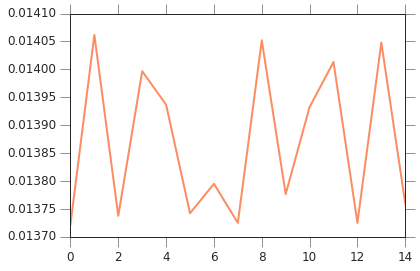

In [13]:
import pylab as plt
%matplotlib inline
plt.plot(costs)

In [10]:
xstd,ystd,angle, xs, ys =  29.46108006,  41.83652597,  -6.43845796,  26.14453125,   1.03125
G = gaussian(xstd,ystd,angle,True)                              
ss = signal.fftconvolve(H_data, G, mode='same')
# remove the cloud pixel
ss[~val_mask]=np.nan
val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
Lvals, Hvals = L_data[val], ss[shx[val], shy[val]]
mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
r

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


LinregressResult(slope=0.8855939893068242, intercept=0.012495603501919, rvalue=0.98627787853593929, pvalue=0.0, stderr=0.0022237142304714387)

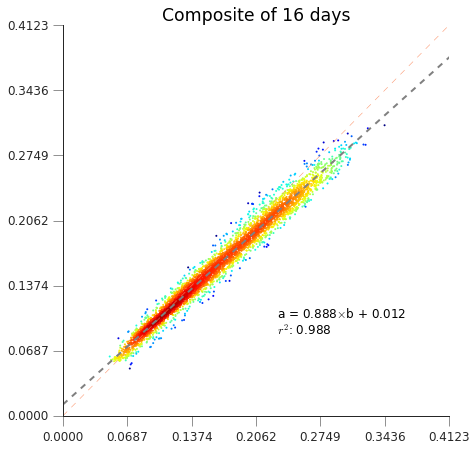

In [14]:
linear_plots([Lvals[mas],], [Hvals[mas],], cmap=plt.cm.get_cmap('jet'), 
             titles=['Composite of 16 days'], three_sigma=1)

In [32]:
def gaussian(xstd, ystd, angle, norm = True):
    win = int(round(max(3*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus 

def cost2(para, H_data=None, L_data=None, val_mask=None):
    xstd,ystd,angle, xs, ys = para 
    G = gaussian(xstd,ystd,angle,True)                              
    ss = signal.fftconvolve(H_data, G, mode='same')
    # remove the cloud pixel
    ss[~val_mask]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals = L_data[val], ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    costs = abs(1-r.rvalue)
    return costs 

def op(p0):
    #p0 =  ps[ind]
    args = H_data, L_data, val_mask
    return optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)

In [ ]:
def Land_PSF_optimization(self):
        self.h,self.v = mtile_cal(self.lat, self.lon)
        m = mgrs.MGRS()
        mg_coor = m.toMGRS(self.lat, self.lon, MGRSPrecision=4)
        self.place = mg_coor[:5]
        #self.Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(self.path, self.row, self.year))
        self.Hfile = os.getcwd()+'/s_data/%s/%s/%s/%d/%d/%d/0/'%(mg_coor[:2], mg_coor[2], mg_coor[3:5], self.year, self.month, self.day)
        #Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]
        self.doy = datetime .datetime(self.year, self.month, self.day).timetuple().tm_yday
        self.Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(self.year,i,self.h,self.v))[0] for i in range(self.doy-8, self.doy+9)]
        
        cl = classification(fhead = self.Hfile, bands = (2,3,4,8,11,12,13), bounds = None)
        cl.Get_cm_p()
        self.cloud = cl.cm.copy()
        self.H_data = cl.b12.copy()
        del cl
        cloud_cover = 1.*cloud.sum()/cloud.size
        if cloud_cover > 0.2:  
            print 'Too much cloud, cloud proportion: %.03f !!'%cloud_cover
        else:
            mete = readxml('%smetadata.xml'%Hfile)
            self.sza = np.zeros(7)
            self.sza[:] = mete['mSz']
            self.saa = self.sza.copy()
            self.saa[:] = mete['mSa']
            self.vza = (mete['mVz'])[[1,2,3,7,8,11,12],]
            self.vaa = (mete['mVa'])[[1,2,3,7,8,11,12],]
            
            self.L_inds, self.H_inds = get_coords(lat,lon)
            self.Lx, self.Ly = self.L_inds
            self.Hx, self.Hy = self.H_inds

            angles = (self.sza[-1], self.vza[-1], (self.vaa - self.saa)[-1])

            self.BRDF_16_days, self.composite_brdf, self.base_mask = self.compositing(angles, thre=0.005)

            struct = ndimage.generate_binary_structure(2, 2)
            dia_cloud = ndimage.binary_dilation(self.cloud, structure=struct, iterations=60).astype(self.cloud.dtype)

            mask = ~(H_data<0).astype('bool')
            small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=60).astype(mask.dtype)
            self.val_mask = (~dia_cloud)&small_mask


            avker = np.ones((120,120))
            navker = avker/avker.sum()
            s = signal.fftconvolve(self.H_data, navker, mode='same')
            s[~val_mask]=np.nan

            self.L_data = self.composite_brdf

            args = s, self.L_data, self.H_data.shape

            retval0=0,0.2
            for xstd0 in range(-30,30,15):
                for ystd0 in range(-30,30,15):
                    p0 = np.array([xstd0, ystd0])
                    retval = optimize.fmin(self._cost1, p0, full_output=1, args=args)
                    if retval[1]<retval0[1]:
                        retval0=retval

            xs, ys = retval[0]
            self.xs, self.ys = xs, ys
            self.p0 = 13, 32, 4, xs, ys
            self.bounds = [5,100],[5,100],[-15,15],[xs-5,xs+5],[ys-5, ys+5]
            #args = H_data, L_data, val_mask
            #optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)

            ps = [(5, 20, 10, xs, ys),(10, 20, 10, xs, ys), (20, 20, 10, xs, ys), (30, 20, 10, xs, ys),(40, 20, 10, xs, ys),
            (10, 5, 10, xs, ys),(10, 10, 10, xs, ys), (10, 20, 10, xs, ys), (10, 30, 10, xs, ys),(10, 40, 10, xs, ys),
            (10, 20, 0, xs, ys),(10, 20, 5, xs, ys), (10, 20, 10, xs, ys), (10, 30, 15, xs, ys),(10, 30, -10, xs, ys)]
            #retval = optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)
            #par = partial(self._op)
            pool = multiprocessing.Pool(processes = 15)
            self.solved = pool.map(op, ps)
            pool.close()
            pool.join()

            return self.solved, self.BRDF_16_days, self.L_data, self.base_mask

In [ ]:
def gaussian(xstd, ystd, angle, norm = True):
    win = int(round(max(3*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus 

def cost2(para, H_data=None, L_data=None, val_mask=None):
    xstd,ystd,angle, xs, ys = para 
    G = gaussian(xstd,ystd,angle,True)                              
    ss = signal.fftconvolve(H_data, G, mode='same')
    # remove the cloud pixel
    ss[~val_mask]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals = L_data[val], ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    costs = abs(1-r.rvalue)
    return costs 

def op(p0):
    #p0 =  ps[ind]
    args = H_data, L_data, val_mask
    return optimize.fmin_l_bfgs_b(cost2, p0, approx_grad=1, iprint=-1, args=args, bounds=bounds)